In [1]:
from plantcv import plantcv as pcv
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats, ndimage, signal
from skimage import filters

import os
from PIL import Image

import pandas as pd

In [2]:
src = '../raw/'
time = '4pm'
rep = 7

foldername = time + ' Inc Rep ' + str(rep)
numfiles = len(glob(src + foldername + '/*.JPG'))

dst = '../preproc/prelim/'

In [3]:
idx = 0
filename = src + foldername + '/' + foldername + ' ({}).JPG'.format(idx+1)
print(filename)

raw1, path, imgname = pcv.readimage(filename, mode='rgb')
mask1, _, _ = pcv.readimage(src + foldername + '/fg_3.tif', mode='rgb')

idx = 901
filename = src + foldername + '/' + foldername + ' ({}).JPG'.format(idx+1)
print(filename)

raw2, path, imgname = pcv.readimage(filename, mode='rgb')
mask2, _, _ = pcv.readimage(src + foldername + '/fg_2.tif', mode='rgb')

raw1 = raw1[:,:,::-1]
raw2 = raw2[:,:,::-1]
mask1 = mask1[:,:,::-1]
mask2 = mask2[:,:,::-1]

../raw/4pm Inc Rep 7/4pm Inc Rep 7 (1).JPG
../raw/4pm Inc Rep 7/4pm Inc Rep 7 (902).JPG


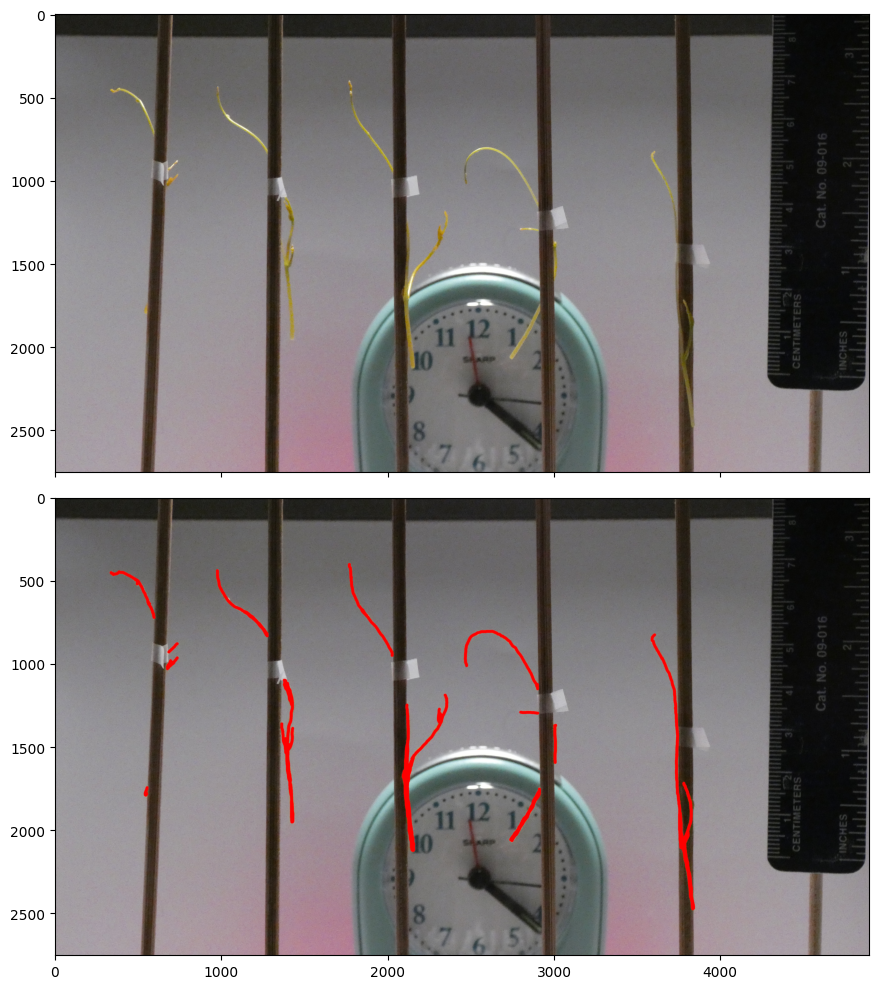

In [4]:
fig, ax = plt.subplots(2,1,figsize=(12,10), sharex=True, sharey=True)

ax[0].imshow(raw1)
ax[1].imshow(mask1)
fig.tight_layout()

In [5]:
rmask = (mask1[:,:,0] == 255) & (mask1[:,:,1] == 0)
fg1 = raw1.copy()
fg1[~rmask] = 0
bg1 = raw1.copy()
bg1[rmask] = 0

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(12,10), sharex=True, sharey=True)

ax[0].imshow(fg1)
ax[1].imshow(bg1)
fig.tight_layout()

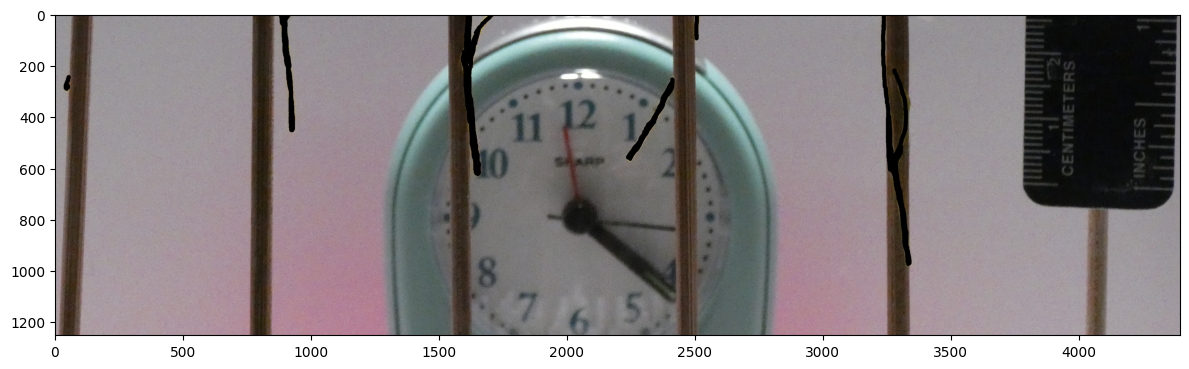

In [35]:
fig, ax = plt.subplots(1,1,figsize=(12,10), sharex=True, sharey=True)
ax.imshow(bg1[1500:, 500:, :])
fig.tight_layout()

In [37]:
bg1 = bg1[1500:, 500:, :]
foo = np.asarray(np.nonzero(np.sum(bg1.astype(int), axis=2))).T
print(foo.shape)

(5430750, 2)


In [38]:
fg_pixels = np.zeros((foo.shape[0], 3), dtype=np.uint8)

for i in range(len(fg_pixels)):
    for j in range(3):
        fg_pixels[i,j] = bg1[foo[i,0], foo[i,1], j]
print(fg_pixels.shape)

(5430750, 3)


In [39]:
bgr_img = cv2.merge((np.asarray(fg_pixels[:,0], dtype=np.uint8),
                     np.asarray(fg_pixels[:,1], dtype=np.uint8),
                     np.asarray(fg_pixels[:,2], dtype=np.uint8)))

foo = np.empty((1625,3342, 3), dtype=np.uint8)

for i in range(3):
    foo[:,:,i] = bgr_img[:,:,i].reshape(1625,3342)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,20))

ax.imshow(foo);

In [41]:
np.save('../raw/bg_pixels', fg_pixels)

# Create PDF

In [ ]:
filename = '../raw/pdfs.txt'

# This is all from the plantcv naive bayes tutorial...
# It's super hacky, but I didn't write it...
# (Which isn't to say I don't write hacky code)

# We only need to run all of this once to get the Probability Density Function files

if not os.path.isfile(filename):
    fg_pixels = np.load('../raw/fg_pixels.npy')
    bg_pixels = np.load('../raw/bg_pixels.npy')

    pdfs = {"hue": {}, "saturation": {}, "value": {}}

    # For each class
    for cls, cls_name in zip([fg_pixels, bg_pixels], ['fg','bg']):
        # Create a blue, green, red-formatted image ndarray with the class RGB values
        bgr_img = cv2.merge((np.asarray(cls[:,2], dtype=np.uint8),
                             np.asarray(cls[:,1], dtype=np.uint8),
                             np.asarray(cls[:,0], dtype=np.uint8)))

        # Convert the BGR ndarray to an HSV ndarray
        hsv_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)

        # Split the HSV ndarray into the component HSV channels
        hue, saturation, value = cv2.split(hsv_img)

        # Create an HSV channel dictionary that stores the channels as lists (horizontally stacked ndarrays)
        channels = {"hue": np.hstack(hue), "saturation": np.hstack(saturation), "value": np.hstack(value)}

        print('For each channel')
        
        for channel in channels:
            # Create a kernel density estimator for the channel values (Gaussian kernel)
            kde = stats.gaussian_kde(channels[channel])
            # Use the KDE to calculate a probability density function for the channel
            pdfs[channel][cls_name] = kde(range(0, 256))

    # Write the PDFs to a text file
    out = open(filename, "w")
    # Write the column labels
    out.write("class\tchannel\t" + "\t".join(map(str, range(0, 256))) + "\n")
    # For each channel
    for channel, cls in pdfs.items():
        # For each class
        for class_name, pdf in cls.items():
            # Each row is the PDF for the given class and color channel
            out.write(class_name + "\t" + channel + "\t" + "\t".join(map(str, pdf)) + "\n")
    out.close()    

In [68]:
# use the plantcv naive bayes classifier to find the flower pixels in the tiny blurred image

mask = pcv.naive_bayes_classifier(rgb_img=raw1,pdf_file="../raw/pdfs.txt")

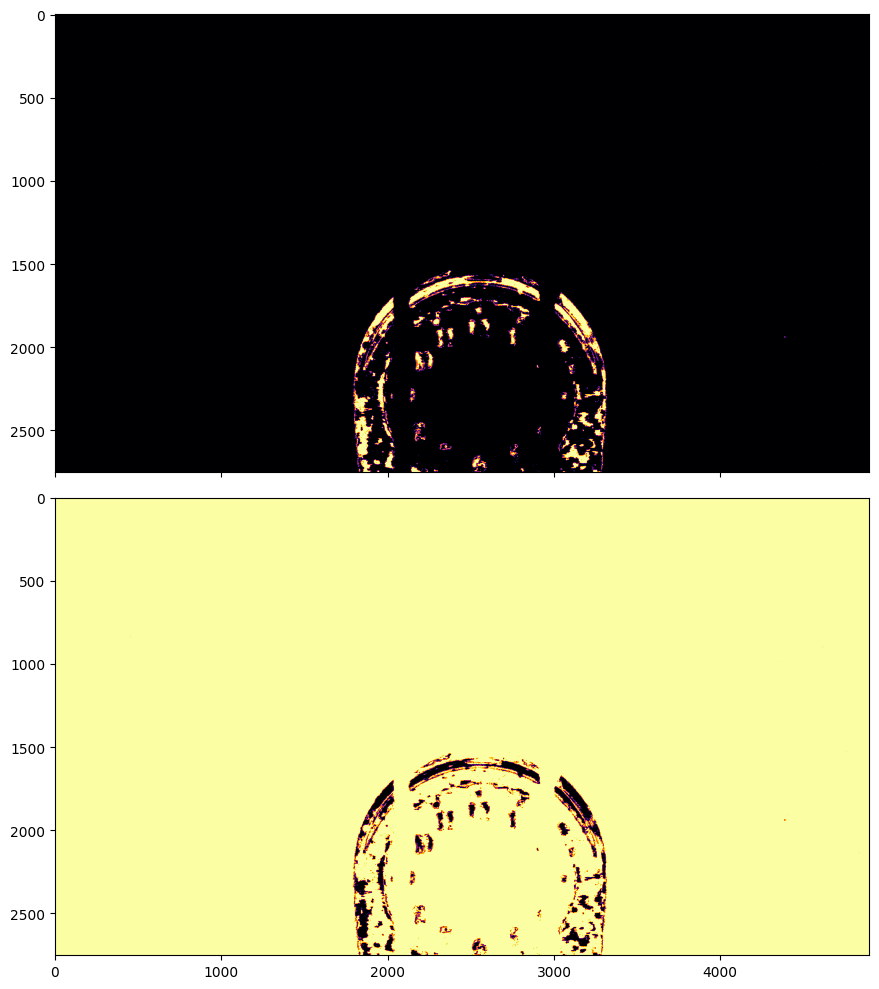

In [74]:
fig, ax = plt.subplots(2,1,figsize=(12,10), sharex=True, sharey=True)

ax[0].imshow(mask['fg'], vmax=255, vmin=0, cmap='inferno')
ax[1].imshow(mask['bg'], vmax=255, vmin=0, cmap='inferno')
fig.tight_layout()

In [57]:
pdfs['bg'].keys()

dict_keys(['hue', 'saturation'])

In [49]:
for i in range(0, width):
        for j in range(0, height):
            for class_name in pdfs.keys():
                # Calculate the joint probability that this is in the class
                px_p[class_name][i][j] = pdfs[class_name]["hue"][h[i][j]] * pdfs[class_name]["saturation"][s[i][j]] * \
                    pdfs[class_name]["value"][v[i][j]]

KeyError: 'value'

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,7), sharex=True, sharey=False)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(img[:,:,0], cmap='Greys_r', vmin=0, vmax=255);
ax[0].plot(10*(medians), c='r', lw=2, zorder=2);
ax[0].scatter(peaks, 10*medians[peaks], c='yellow', marker='^', zorder=3);
#ax[0].plot(10*(maxis), c='b', lw=2);

In [ ]:
buffx = 100
buffy = 50
stick = []

stick.append(np.s_[buffx:-buffx, 0:peaks[1]-buffy, :])
for i in range(1, len(peaks)-1):
    stick.append(np.s_[buffx:-buffx, peaks[i-1]+buffy:peaks[i+1]-buffy, :])
print(len(stick))

In [ ]:
jdx = 4
fig, ax = plt.subplots(2,len(stick),figsize=(12,10))

ax = ax.ravel()

for i in range(len(stick)):
    ax[i].imshow(img[stick[i]][:,:,::-1]);
    ax[i].axis('off')
    
    ax[i+5].imshow(np.max(img[stick[i]], axis=2), vmax=1)
    ax[i+5].axis('off')

fig.tight_layout()

In [ ]:
i = 0

hsv = cv2.cvtColor(img[stick[i]], cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)

fig, ax = plt.subplots(1,4,figsize=(12,7), sharex=True, sharey=True)

ax[0].imshow(h, cmap='inferno');
ax[1].imshow(s, cmap='inferno');
ax[2].imshow(v, cmap='inferno', vmin=0, vmax=255);
ax[3].imshow(img[stick[i]])

fig.tight_layout()

In [ ]:
plt.imshow(v > 62, cmap='Greys_r');